In [1]:
from fastai.vision.all import *
from pathlib import Path
import h5py
from matplotlib import cm
import PIL

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
path = '/kaggle/input/jet-images-train-val-test/jet-images_train.hdf5'
classes = ["general", "W-boson"]
    
h5_file = h5py.File(path, 'r')
signal_data = h5_file['signal']
image_data = h5_file['image']

def label_func(x):
    signal = signal_data[int(x)]
    return classes[int(signal)]

def get_items(x):
    l = len(image_data)
    return [str(i) for i in range(l)]

def get_x(x):
    return torch.from_numpy(image_data[int(x)])


In [3]:
train_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_items,
                   get_x = get_x,
                   get_y     = label_func,
                   splitter  = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[Resize(200, method='squish')])

In [4]:
dls_train = train_dblock.dataloaders(path)

In [5]:
xb, yb = dls_train.one_batch()
print(xb.shape)

torch.Size([64, 1, 200, 200])


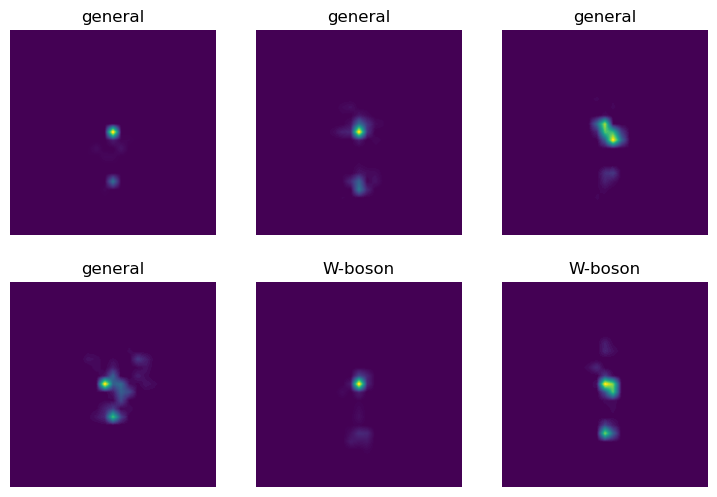

In [6]:
dls_train.show_batch(max_n=6)

In [7]:
learn = vision_learner(dls_train,arch='convnext_tiny',  metrics=accuracy, n_in=1)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


In [8]:
#lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [9]:
learn.fine_tune(
    20, 
    #lrs.valley 
    cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=4)
)

epoch,train_loss,valid_loss,accuracy,time
0,0.416589,0.408287,0.816702,37:44


epoch,train_loss,valid_loss,accuracy,time
0,0.397855,0.391338,0.825487,2:01:52
1,0.397033,0.402274,0.821978,2:01:53
2,0.400477,0.397365,0.824683,2:01:56
3,0.399927,0.398900,0.821747,2:01:55
4,0.396406,0.408270,0.821182,2:01:53


No improvement since epoch 0: early stopping


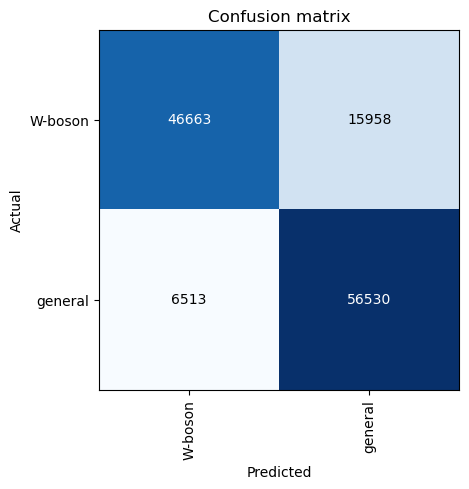

In [10]:
learn_int = ClassificationInterpretation.from_learner(learn)
learn_int.plot_confusion_matrix()

In [11]:
path = '/kaggle/input/jet-images-train-val-test/jet-images_val.hdf5'
classes = ["general", "W-boson"]
    
h5_file = h5py.File(path, 'r')
signal_data = h5_file['signal']
image_data = h5_file['image']



def label_func(x):
    signal = signal_data[int(x)]
    return classes[int(signal)]

def get_items(x):
    l = len(image_data)
    return [str(i) for i in range(l)]

def get_x(x):
    return torch.from_numpy(image_data[int(x)])

In [12]:
val_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_items,
                   get_x = get_x,
                   get_y     = label_func,
                   splitter  = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[Resize(200, method='squish')])

In [13]:
dls_val = val_dblock.dataloaders(path)

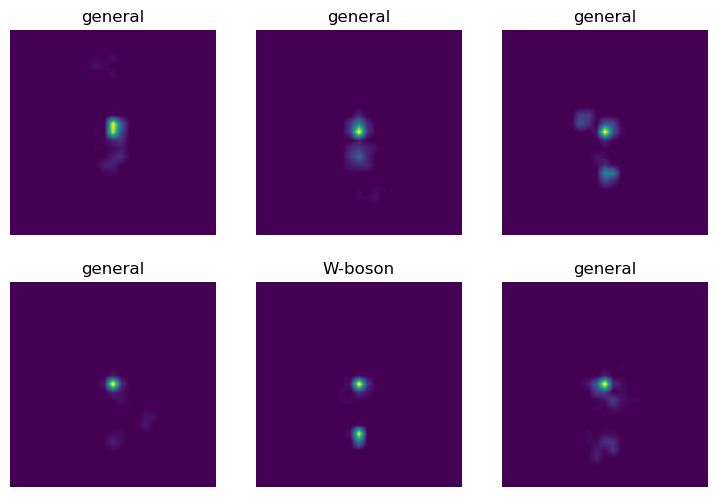

In [14]:
dls_val.show_batch(max_n=6)

In [15]:
learn.dls= dls_val

In [16]:
learn.fine_tune(
    0, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=4),
)

epoch,train_loss,valid_loss,accuracy,time
0,0.400126,0.386640,0.828495,09:44


In [17]:
learn_int = ClassificationInterpretation.from_learner(learn)

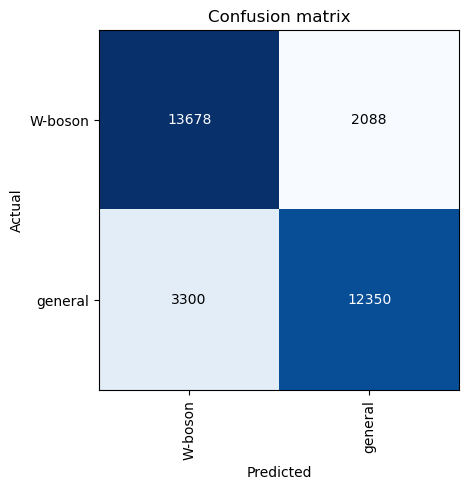

In [18]:
learn_int.plot_confusion_matrix()